# Creating instrument responses for APTs

Related to: https://gist.github.com/MHee/c4155caea6df1b9fa2d7a5146820f7cf

Below is example code to generate, and subsequently write, a StationXML Inventory for a low-rate acceleration channel for the APT, which will comprise the instrument response portion of the metadata for NV.NC89.Z1.MNE.

Frequency-phase response transfer functions for the APT are accounted for by a simple unitary numerator/denominator coefficients type response stage with zero uncertainty in their values. The result is a uniform transfer function w.r.t. frequency and phase. Frequency response sensitivity amplitudes are represented specifically to convert 32 bit integers to engineering units for each geophysical sensor. See "Related to: ". 

# Remarks on pressure, temperature and ASCII data

StationXML Inventories (and thus instrument response representation) have not been generated for the ASCII data, and I am unsure how to create the metadata for these channels (i.e., AED, AHD, and ALD).

ObsPy is doubly picky about the unit choice when it comes to creating instrument responses. Temeprature and pressure frequency-phase response transfer functions were created the same way as the ones for acceleration, using of course the appropriate scaling factor. Although ObsPy isn't able to plot these, they essentially appear the same, but have their corresponding sensitivity amplitude.

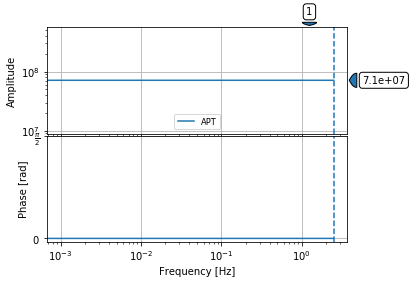

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 15 14:37:00 2018

@author: jfarrugia
"""

%matplotlib inline
from obspy.core.inventory import response as rp
from obspy import Inventory
from obspy.core.inventory import Network, Station, Channel, Site
import obspy
from datetime import datetime

def create_response(inputsamplerate=20.0, scaling_factor=1.4e-8, units='M/S**2'):
    _response = rp.Response(
            instrument_sensitivity=rp.InstrumentSensitivity(1.0/scaling_factor, 
                                                            1.0, 
                                                            input_units=units, 
                                                            output_units='COUNTS'
                                                            ), 
            response_stages=[
                    rp.CoefficientsTypeResponseStage(
                            stage_sequence_number=1, 
                            stage_gain=1.0/scaling_factor, 
                            stage_gain_frequency=1.0, 
                            input_units=units, 
                            output_units='COUNTS', 
                            cf_transfer_function_type='DIGITAL', 
                            numerator=rp.FloatWithUncertaintiesAndUnit(1), 
                            denominator=rp.FloatWithUncertaintiesAndUnit(1), 
                            decimation_input_sample_rate=inputsamplerate, 
                            decimation_delay=0.0, 
                            decimation_factor=1, 
                            decimation_correction=0.0, 
                            decimation_offset=0
                            )
                    ]
            )
    if units=='M/S**2':
        _response.recalculate_overall_sensitivity()
        _response.plot(1e-3, output='ACC', label='APT')
        
    return _response

def create_inv(network_code, station_code, location_code, channel_code, isr, sf, u):
    writethisinv = Inventory(
            networks = [Network(code=network_code,
                                start_date=obspy.UTCDateTime('2007-01-01'),
                                stations=[Station(code=station_code,
                                                  latitude=1, 
                                                  longitude=2, 
                                                  elevation=3,
                                                  creation_date=obspy.UTCDateTime('2007-01-01'),
                                                  site=Site(name='site'),
                                                  channels=[Channel(code=channel_code, 
                                                                    location_code = location_code,
                                                                    start_date=obspy.UTCDateTime('2007-01-01'),
                                                                    latitude = 1, 
                                                                    longitude = 2, 
                                                                    elevation = 3, 
                                                                    depth = 4, 
                                                                    response=create_response(inputsamplerate=isr, scaling_factor=sf, units=u)
                                                                    )])])], 
            source='Joseph Farrugia, Ocean Networks Canada', # The source should be the id whoever create the file.
            created = obspy.UTCDateTime(datetime.today())
                )
    return writethisinv

#%%write inventories
inv = create_inv(network_code='NV', station_code='NC89', location_code='Z1', channel_code='MNE', isr=5.0, sf=1.4e-8, u='M/S**2')
inv.write(r'\\onc-fileserver\redirect4\jfarrugia\Documents\GitHub\StationXML_NV\{}.xml'.format(inv.get_contents()['channels'][0]), format='stationxml')

In [4]:
print(inv)

Inventory created at 2018-08-16T11:22:43.490752Z
	Created by: ObsPy 1.1.0
		    https://www.obspy.org
	Sending institution: Joseph Farrugia, Ocean Networks Canada
	Contains:
		Networks (1):
			NV
		Stations (1):
			NV.NC89 (site)
		Channels (1):
			NV.NC89.Z1.MNE


In [5]:
print(inv[0][0][0].response)

Channel Response
	From M/S**2 () to COUNTS ()
	Overall Sensitivity: 7.14286e+07 defined at 1.250 Hz
	1 stages:
		Stage 1: CoefficientsTypeResponseStage from M/S**2 to COUNTS, gain: 7.14286e+07
